# Model training 
First iteration of model training 

Packages 

In [1]:
#Change working directory to project direcgtory
import os

current_directory = os.getcwd()
project_name = 'bcppmchurn'
project_path = os.path.join(current_directory.split(project_name)[0], project_name)
os.chdir(project_path)
print(os.getcwd())  

/Users/hamza_hajjini/Desktop/DATA/HAMAZA_HAJJINI/projects/bcppmchurn


In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import os
from datetime import datetime 
import random
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.svm import SVC
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import xgboost as xgb
import pickle 
import json

from src.logger import logging
from src.logger_class import setup_logger
from src.eda import utils
from src.eda.utils import columnsFamilies

In [107]:
#Get todays's date
date_time = datetime.today().strftime("%Y-%m-%d")
#Declare paths
train_dev_test_path = "data/train_dev_test"
data_path = "data/experiments_data"
data_samples_path = "data/data_samples"
artifacts_path = "artifacts/eda"
x_y_sets_path = "data/x_y_sets"
models_path = "models/ml_models"
models_ressources_path = "models/ressources"

In [5]:
#Reload modules in case a change has occured
#import importlib
#from src.components import data_ingestion, data_structuring
#importlib.reload(data_ingestion)
#importlib.reload(data_structuring)

### Loding data

--------------------

In [54]:
#Loading data
data_date = "2024-10-22"
x_train = pd.read_csv(f"{x_y_sets_path}/{data_date}_x_train_norm.csv", index_col = 0)
x_dev = pd.read_csv(f"{x_y_sets_path}/{data_date}_x_dev_norm.csv", index_col = 0)
x_test = pd.read_csv(f"{x_y_sets_path}/{data_date}_x_test_norm.csv", index_col = 0)
y_train = pd.read_csv(f"{x_y_sets_path}/{data_date}_y_train.csv", index_col = 0)
y_dev = pd.read_csv(f"{x_y_sets_path}/{data_date}_y_dev.csv", index_col = 0)
y_test = pd.read_csv(f"{x_y_sets_path}/{data_date}_y_test.csv", index_col = 0)

print (f"x_train shape : {x_train.shape}")
print (f"y_train shape : {y_train.shape}")
print ("------------------")
print (f"x_dev shape : {x_dev.shape}")
print (f"y_dev shape : {y_dev.shape}")
print ("------------------")
print (f"x_test shape : {x_test.shape}")
print (f"y_test shape : {y_test.shape}")

x_train shape : (86992, 531)
y_train shape : (86992, 1)
------------------
x_dev shape : (14563, 531)
y_dev shape : (14563, 1)
------------------
x_test shape : (5839, 531)
y_test shape : (5839, 1)


In [55]:
#target value_counts
print ("y_train counts")
print (y_train.value_counts())
print ("-------------")
print ("y_dev counts")
print (y_dev.value_counts())
print ("-------------")
print ("y_test counts")
print (y_test.value_counts())

y_train counts
churn
1        43700
0        43292
Name: count, dtype: int64
-------------
y_dev counts
churn
1        7325
0        7238
Name: count, dtype: int64
-------------
y_test counts
churn
1        2938
0        2901
Name: count, dtype: int64


In [56]:
#transform y to array
y_train = y_train.values.flatten()
y_dev = y_dev.values.flatten()
y_test = y_test.values.flatten()
print (f"y_train length : {len(y_train)}")
print (f"y_dev length : {len(y_dev)}")
print (f"y_test length : {len(y_test)}")

y_train length : 86992
y_dev length : 14563
y_test length : 5839


In [58]:
from sklearn.preprocessing import StandardScaler

train_tenure = pd.read_csv(f"data/experiments_data/{date_time}_train_tenure.csv")
dev_tenure = pd.read_csv(f"data/experiments_data/{date_time}_dev_tenure.csv")
test_tenure = pd.read_csv(f"data/experiments_data/{date_time}_test_tenure.csv")
train_tenure.rename(columns={"activation_bscs_date": "tenure"}, inplace=True)
dev_tenure.rename(columns={"activation_bscs_date": "tenure"}, inplace=True)
test_tenure.rename(columns={"activation_bscs_date": "tenure"}, inplace=True)

In [69]:
train_tenure

,tenure
0,2494
1,2971
2,377
3,63
4,302
...,...
86987,114
86988,895
86989,32
86990,195


In [70]:
standard_scaler = StandardScaler().fit(train_tenure)
train_tenure = standard_scaler.transform(train_tenure)
dev_tenure = standard_scaler.transform(dev_tenure)
test_tenure = standard_scaler.transform(test_tenure)

In [71]:
x_train["tenure"] = train_tenure 
x_dev["tenure"] = dev_tenure
x_test["tenure"] = test_tenure

In [114]:
x_train = x_train[list(x_train.columns[:-2])+["tenure", "gamme_encoded"]]
x_dev = x_dev[list(x_dev.columns[:-2])+["tenure", "gamme_encoded"]]
x_test = x_test[list(x_test.columns[:-2])+["tenure", "gamme_encoded"]]

-------------------

### Model training 

#### XGBoost

In [116]:
#Data to DMatrix
dtrain = xgb.DMatrix(data=x_train, label=y_train)
ddev = xgb.DMatrix(data=x_dev, label=y_dev)
dtest = xgb.DMatrix(data=x_test, label=y_test)
evals = [(dtrain, "train"), (ddev, "dev")]
eval_hist = {}

In [117]:
#Model parameters 
params_2 = {
    'objective': 'binary:logistic',  
    'eval_metric': 'logloss',       
    'eta': 0.1,                     
    'max_depth': 5,                  
    'subsample': 0.9,                 
    'colsample_bytree': 1,           
    'min_child_weight': 1,            
    'gamma': 0.1,                     
    'scale_pos_weight': 1,                        
    'learning_rate': 0.01
}

In [118]:
#Trianing model
XGB_MODEL = None
XGB_MODEL = xgb.train( params = params_2,
                        dtrain=dtrain,
                        num_boost_round=10000,
                        evals=evals,
                        evals_result=eval_hist,
                        early_stopping_rounds=30,  #Stop early if no improvement
                        verbose_eval=True
                    )

[0]	train-logloss:0.68771	dev-logloss:0.68772
[1]	train-logloss:0.68243	dev-logloss:0.68246
[2]	train-logloss:0.67711	dev-logloss:0.67720
[3]	train-logloss:0.67202	dev-logloss:0.67215
[4]	train-logloss:0.66704	dev-logloss:0.66720
[5]	train-logloss:0.66214	dev-logloss:0.66234
[6]	train-logloss:0.65738	dev-logloss:0.65761
[7]	train-logloss:0.65271	dev-logloss:0.65298
[8]	train-logloss:0.64812	dev-logloss:0.64844
[9]	train-logloss:0.64347	dev-logloss:0.64381
[10]	train-logloss:0.63887	dev-logloss:0.63925
[11]	train-logloss:0.63449	dev-logloss:0.63490
[12]	train-logloss:0.63018	dev-logloss:0.63063
[13]	train-logloss:0.62599	dev-logloss:0.62648
[14]	train-logloss:0.62171	dev-logloss:0.62223
[15]	train-logloss:0.61750	dev-logloss:0.61806
[16]	train-logloss:0.61339	dev-logloss:0.61398
[17]	train-logloss:0.60932	dev-logloss:0.60995
[18]	train-logloss:0.60552	dev-logloss:0.60618
[19]	train-logloss:0.60162	dev-logloss:0.60232
[20]	train-logloss:0.59775	dev-logloss:0.59847
[21]	train-logloss:0.59

In [ ]:
#Load ressources 
"""with open(f"{models_ressources_path}/2024-10-30_eval_hist_xgboost1.json", "r") as f:
    eval_hist = json.load(f)"""
"""with open("models/ml_models/2024-10-25_xgb_model.pkl", "rb") as f:
    XGB_MODEL = pickle.load(f)"""

#### Model Performances

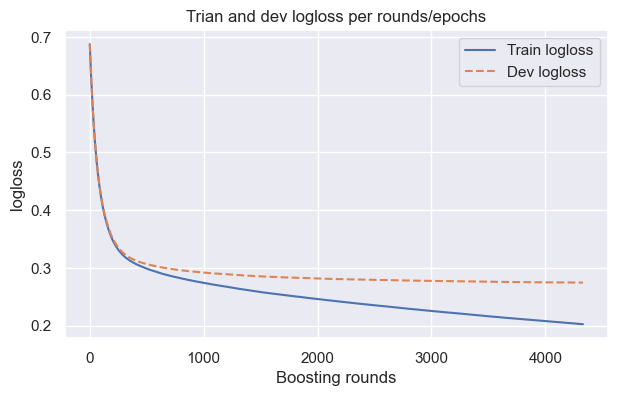

In [119]:
#Plot log loss
utils.vis_training_metric(eval_hist, eval_metric="logloss")

In [120]:
#Predictions
y_test_predicted_prob = XGB_MODEL.predict(dtest)
y_train_predicted_prob = XGB_MODEL.predict(dtrain)
#Transform probas into predictions
THRESHOLD = 0.35
y_test_pred = [int(y_test_predicted_prob[i]>THRESHOLD) for i in range(len(y_test_predicted_prob))]
y_train_pred = [int(y_train_predicted_prob[i]>THRESHOLD) for i in range(len(y_train_predicted_prob))]

                  train set      ||     test set
------------------------------------------------------------
xgboost accuracy      : 0.9302694500643738  ||  0.8811440315122453
xgboost precision     : 0.9269410536824432  ||  0.8824130879345603
xgboost recall        : 0.9348741418764303  ||  0.8812117086453369
xgboost f1 score      : 0.9308906965616242  ||  0.8818119891008175
-------------------------------------------------------------


/Users/hamza_hajjini/Desktop/DATA/HAMAZA_HAJJINI/projects/bcppmchurn/src/eda/utils.py:291: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


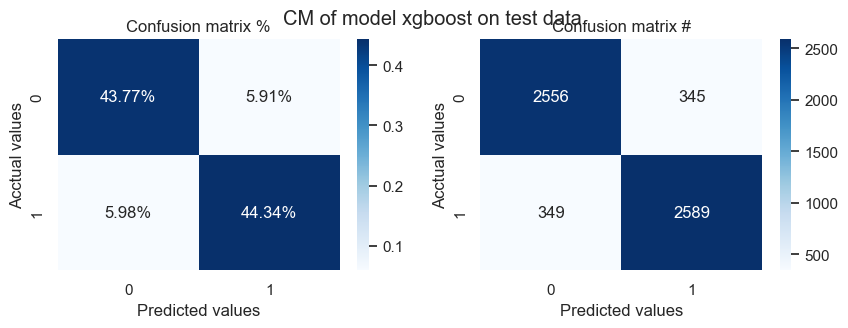

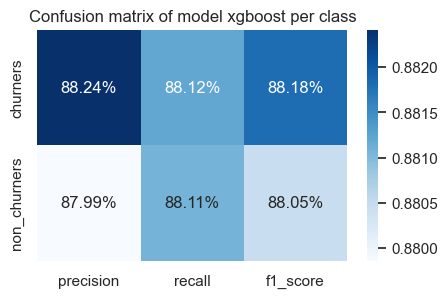

In [122]:
#Visualize model performance
utils.report_model_performances(y_test, y_test_pred, y_train, y_train_pred, model_name = "xgboost")

#### Model calibration 

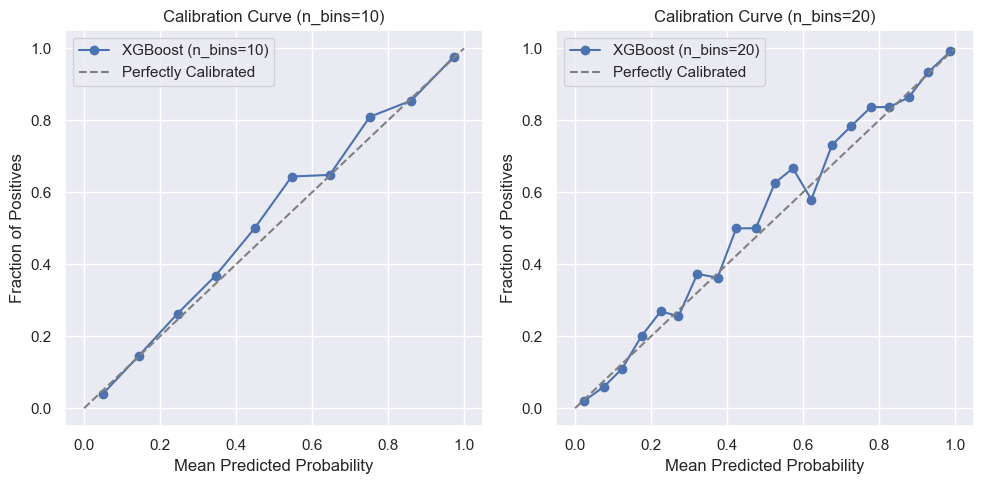

In [123]:
#Plot calibration curve 
utils.vis_calibration_curve(n_bins=[10, 20], y_test=y_test, y_test_predicted_prob=y_test_predicted_prob)

#### ROC curve 

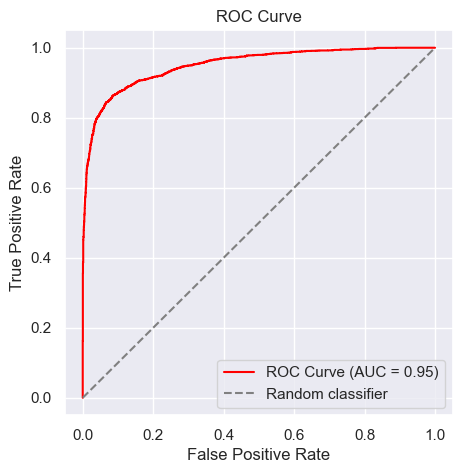

In [124]:
#Plot roc curve 
utils.vis_roc_curve(y_test, y_test_predicted_prob)

#### Feature importance 

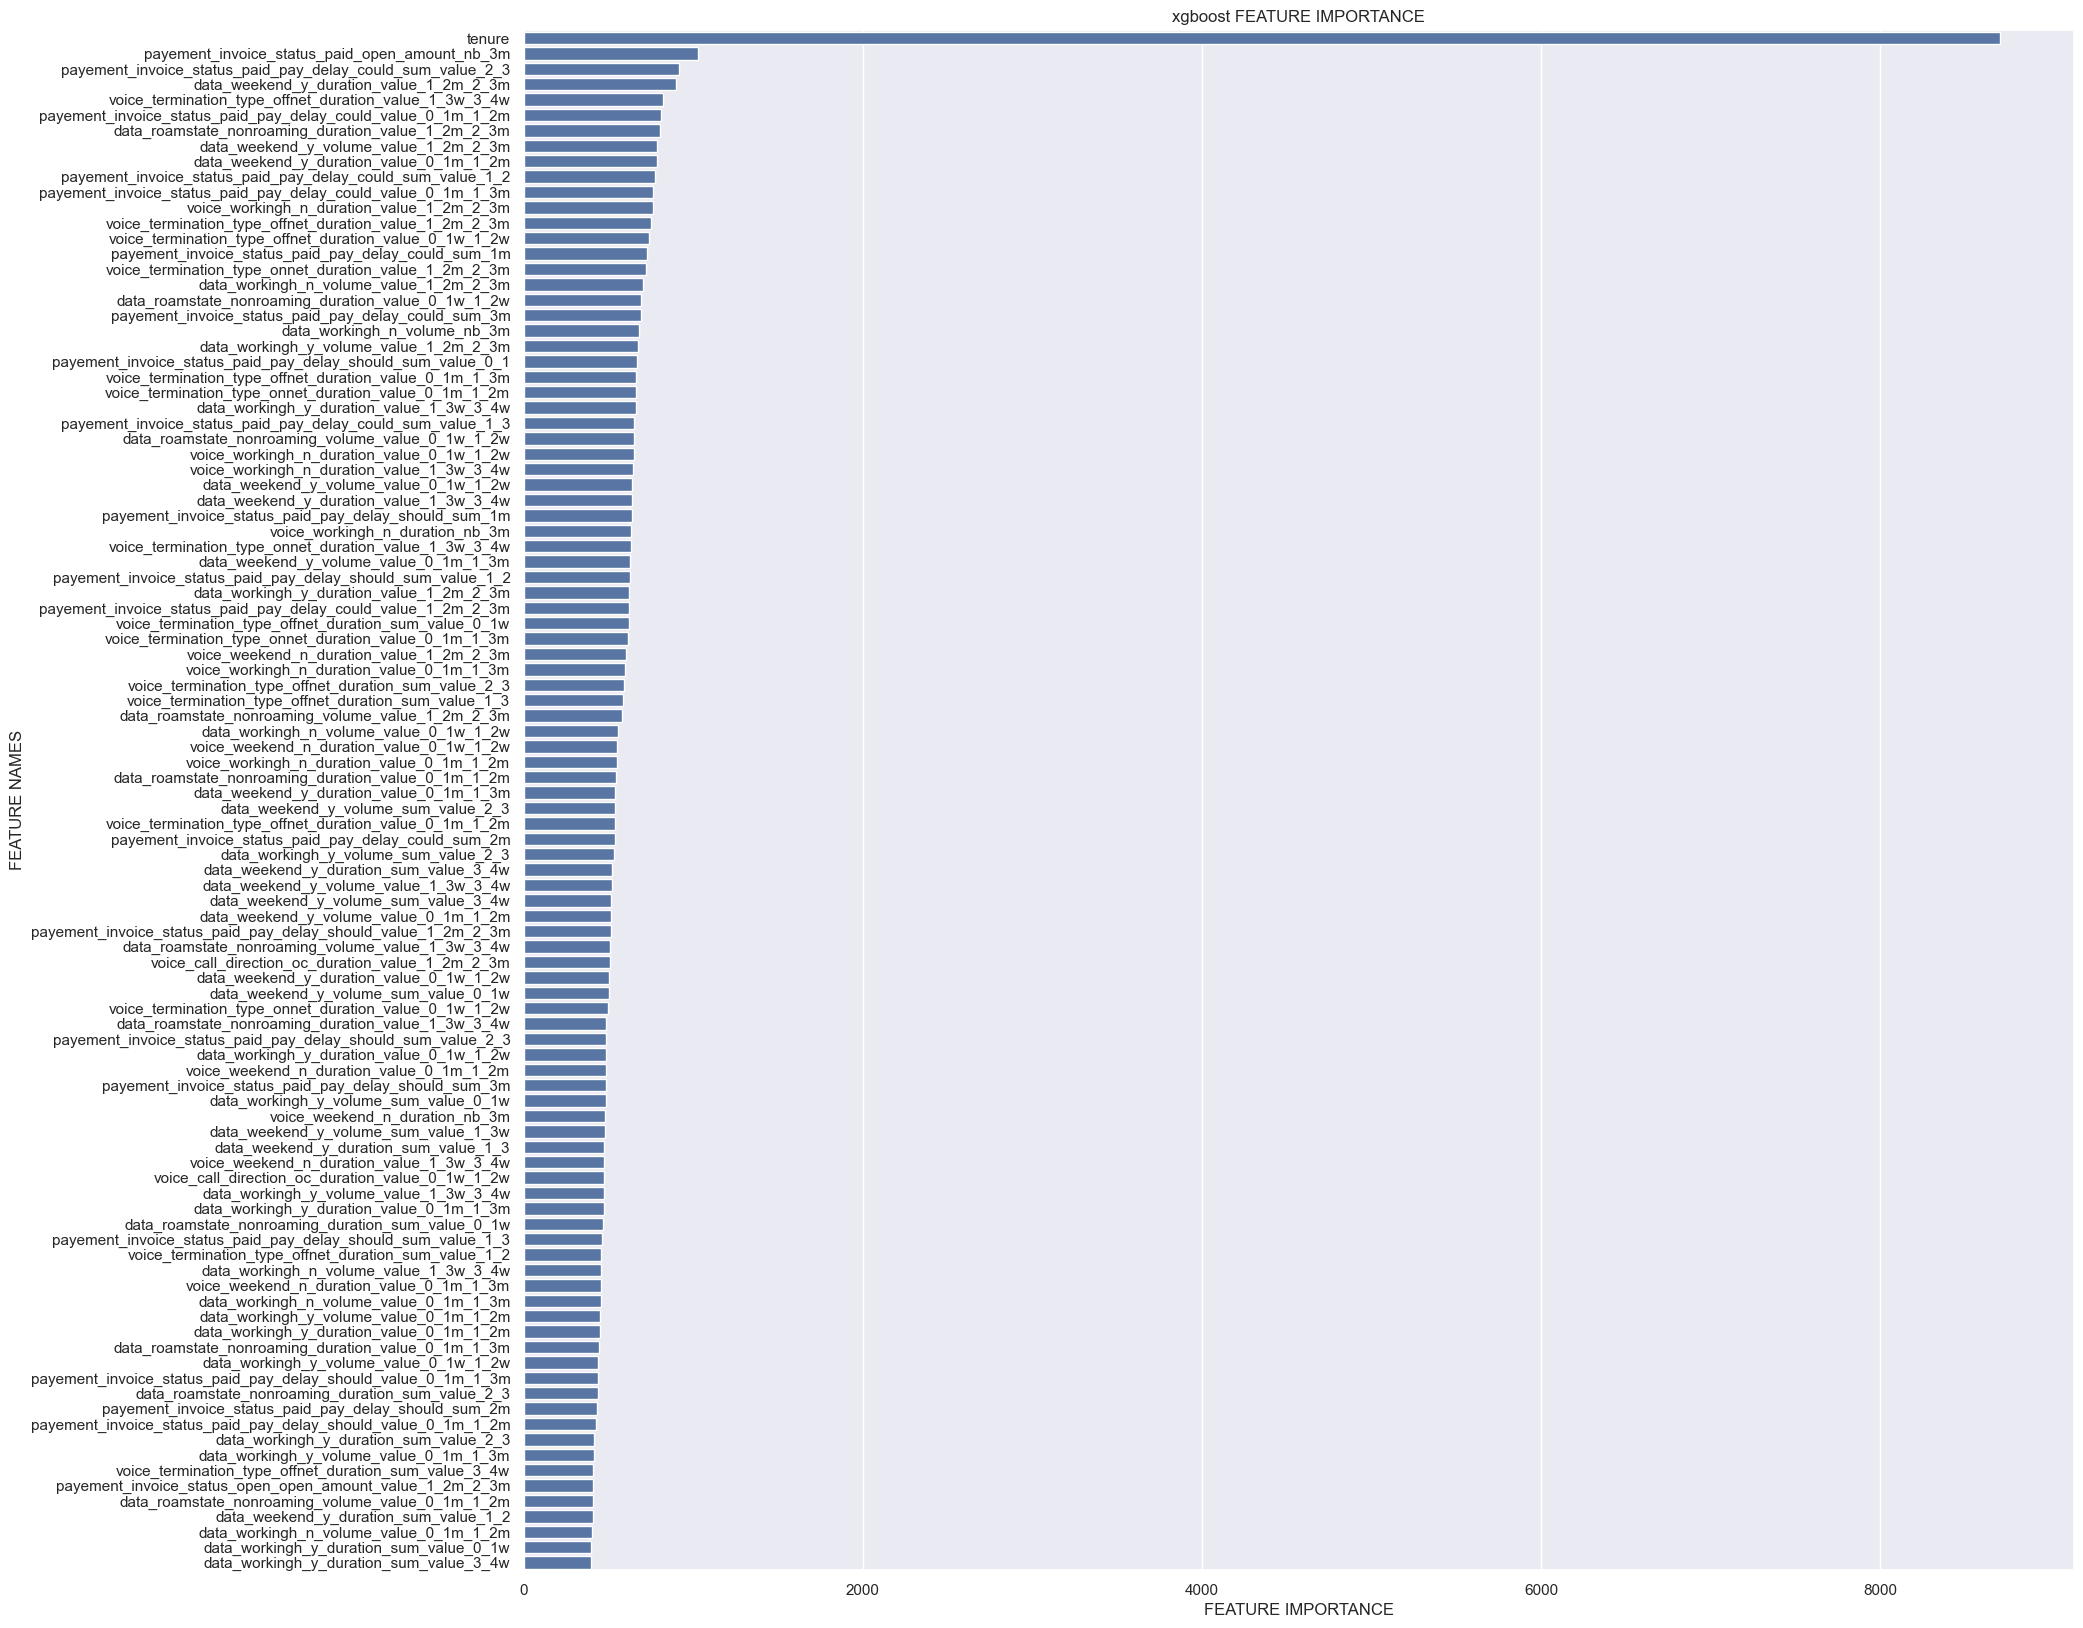

In [125]:
#Get feature importance from model
importance =  XGB_MODEL.get_score(importance_type = "weight")
#Plot importance
utils.plot_feature_importance(importance.values(), importance.keys(), model_type="xgboost", max_n_features=100, figsize=(20, 20))

In [ ]:
#Save feature importance
importance_df = pd.DataFrame()
importance_df["feature_names"] = importance.keys()
importance_df["feature_importance"] = importance.values()
importance_df.sort_values(by="feature_importance", inplace=True, ascending=False)
#Save features
#importance_df.to_csv(f"models/ressources/2024-10-25_feature_importance.csv", index=False)

,feature_names,feature_importance
290,payement_invoice_status_paid_pay_delay_could_s...,775.0
68,payement_invoice_status_paid_open_amount_nb_3m,659.0
403,data_roamstate_nonroaming_duration_value_1_2m_...,527.0
328,data_weekend_y_duration_value_0_1m_1_2m,411.0
124,payement_invoice_status_open_open_amount_sum_3m,392.0


#### Actual points and predicted points density

Applying tsne on data
Ploting data distribution


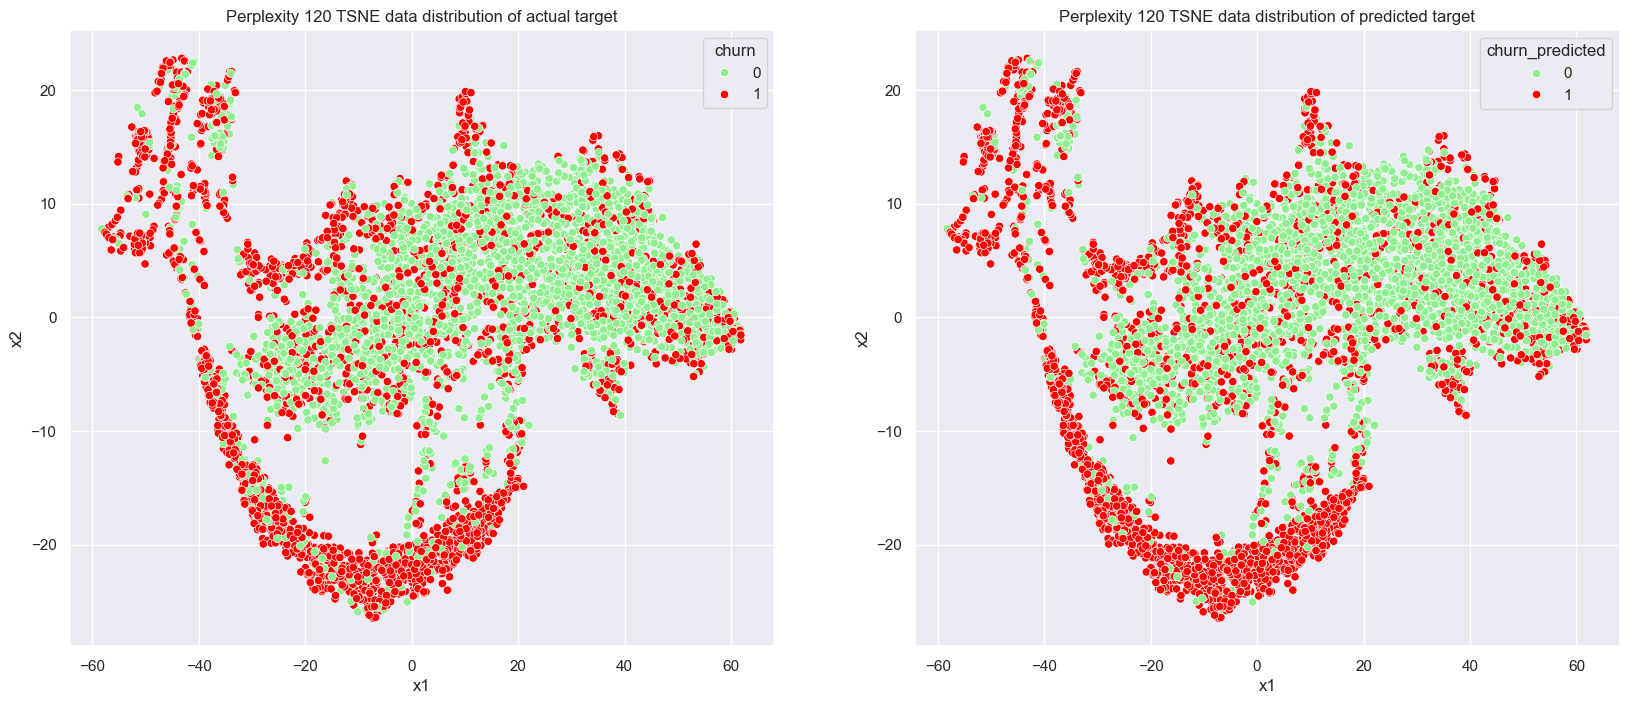

In [126]:
#Apply tsne for data distribution visualization
utils.vis_data_distribution_of_acctual_and_predicted_target_with_tsne(x_test, y_test, y_test_pred)

#### Count of correct and wrong scores 

<Axes: title={'center': 'Number of mistakes and correct score predictions by range'}, xlabel='Score ranges', ylabel='Score count'>

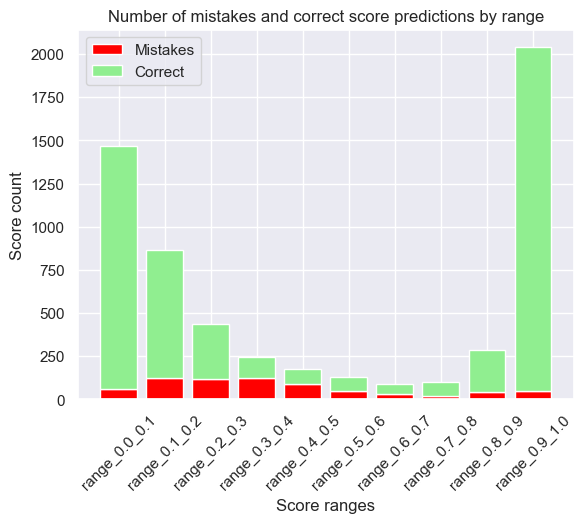

In [127]:
utils.vis_count_mistakes_and_correct_scores(y_test, y_test_pred, y_test_predicted_prob)

#### Precision recall per thereshold values

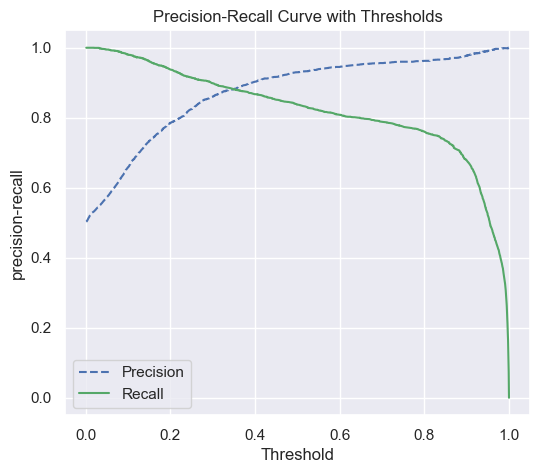

In [129]:
#Precision recall curve
utils.vis_precision_recall_thereshold(y_test, y_test_predicted_prob)

#### Save model 

!!!!!!!!!!!!!!!!!! be careful not to touch something bellow befor checking the saving config !!!!!!!!!!!!!!!!!!

In [130]:
#Save model as pickle file 
pickle.dump(XGB_MODEL, open(f"{models_path}/{date_time}_xgb_model_with_tenure.pkl", "wb"))

In [ ]:
#Save model as json file
#XGB_MODEL.save_model(f"{models_path}/{date_time}_xgb_model.json")

In [ ]:
#Save model feature names
inference_feature_names = XGB_MODEL.feature_names
with open("models/ressources/2024-10-25_inference_feature_names.txt", "w") as f:
    f.write(str(inference_feature_names))

In [342]:
#Load model
#with open(f"{models_path}/2024-10-25_xgb_model.pkl", "rb") as f:
#    t_model = pickle.load(f)

### Testst

Let's visualize some plots about tenure

In [133]:
df_train = x_train.copy()
df_train["churn"] = y_train
df_train.head()

,complaints_complaints_complaint_status_resolu_duration_nb_1m,complaints_complaints_complaint_status_resolu_total_nb_1m,complaints_complaints_complaint_type_reclamation_total_nb_1m,complaints_complaints_complaint_type_retention_total_nb_1m,complaints_complaints_weekend_n_duration_nb_1m,complaints_complaints_weekend_n_total_nb_1m,complaints_complaints_workingh_y_duration_nb_1m,complaints_complaints_workingh_y_total_nb_1m,data_roamstate_nonroaming_duration_nb_1m,data_workingh_n_volume_nb_1m,...,voice_call_direction_oc_duration_value_1_3w_3_4w,voice_destination_type_international_duration_value_1_3w_3_4w,voice_destination_type_national_duration_value_1_3w_3_4w,voice_termination_type_offnet_duration_value_1_3w_3_4w,voice_termination_type_onnet_duration_value_1_3w_3_4w,voice_weekend_n_duration_value_1_3w_3_4w,voice_workingh_n_duration_value_1_3w_3_4w,tenure,gamme_encoded,churn
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,315.0,202.0,...,4.574711,0.0,4.574711,3.367296,4.234107,3.367296,4.234107,3.619176,1,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,807.0,367.0,...,1.286592,0.0,1.294903,0.982976,1.717072,1.328973,1.630342,4.451330,3,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,164.0,150.0,...,0.949891,0.0,0.949891,-3.555348,0.953837,1.313691,1.253288,-0.074056,1,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,357.0,154.0,...,-0.499077,0.0,-0.499077,0.579522,-0.522091,-0.243819,-0.109098,-0.621847,1,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,532.0,264.0,...,-0.230370,0.0,-0.230370,0.000000,-0.230370,-0.722613,0.207521,-0.204898,1,0


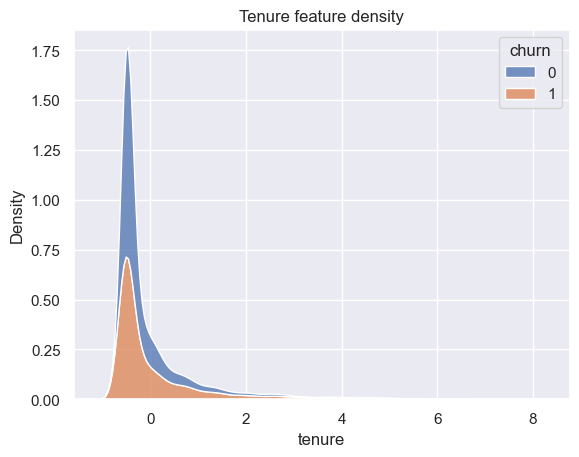

In [137]:
#Tenure density 
sns.kdeplot(data= df_train, x="tenure", hue="churn", multiple="stack")
plt.title("Tenure feature density")
plt.show()

In [ ]:
tenure_sorted = df_train[["tenure"]].sort_values(by="tenure", ascending=True)
tenure_sorted = tenure_sorted.reset_index(drop=True)
tenure_sorted ["churn"] = df_train["churn"].values
tenure_sorted

<Axes: xlabel='None', ylabel='tenure'>

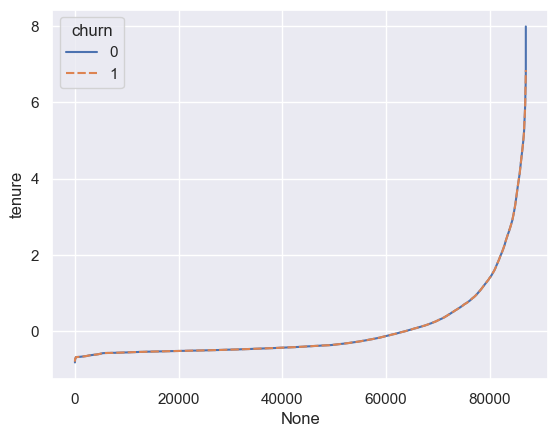

In [165]:
sns.lineplot(data = tenure_sorted, x=tenure_sorted.index, y="tenure", hue="churn", style="churn", markers=False)